In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np

Global seed set to 0


In [2]:
savings_directory = '/nfs/team283/aa16/data/cell2fate/trained_models/'

# Parameter settings for this run:
max_epochs = 1000
learning_rate = 0.01
batch_size = None
posterior_samples = 5

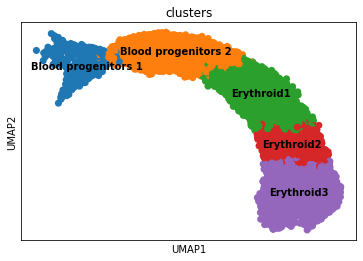

In [3]:
adata = sc.read_h5ad('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/MouseErythroid_anndata.h5ad')
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

We register the anndata object and create the model instance as with other scvi-tools methods.

Keeping at most 100000 cells per cluster
Filtered out 47456 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.


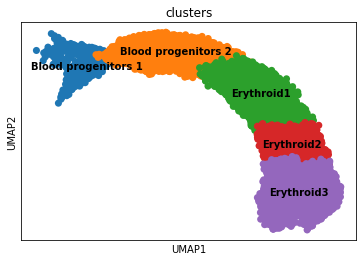

In [4]:
remove_clusters = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = remove_clusters,
                                min_shared_counts = 20, n_var_genes= 2000)
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

Initialize the model:

In [5]:
n_modules = 5

In [6]:
c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata(adata,
                                                                                    spliced_label='spliced',
                                                                                    unspliced_label='unspliced')

In [7]:
mod = c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime(adata,
                                                        stochastic_v_ag_hyp_prior={"alpha": 3.0, "beta": 3.0},
                                                        detection_hyp_prior={"alpha": 10.0, "mean_alpha": 1.0, "mean_beta": 1.0},
                                                        Tmax_prior={"mean": 50, "sd": 50},
                                                       n_modules = n_modules)
#                                                        init_vals = init_vals)

In [8]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata` 
with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 9815  │
│      n_vars      │ 2000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

The lower the learning rate and the higher the number of iterations, the better the results. For example a learning rate of 0.001 and 100000 iterations will give slightly better results than here and a learning rate 0.1 and just 100 iterations will give slightly worse results, but has the upside of a very short training time.

In [9]:
mod.train(use_gpu=True, batch_size = batch_size, max_epochs = max_epochs, lr = learning_rate)
# mod.train(use_gpu=True, batch_size = batch_size, max_epochs = 1, lr = 10**(-10)) # (For checking initial values)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:56<00:00,  2.40it/s, v_num=1, elbo_train=2.38e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

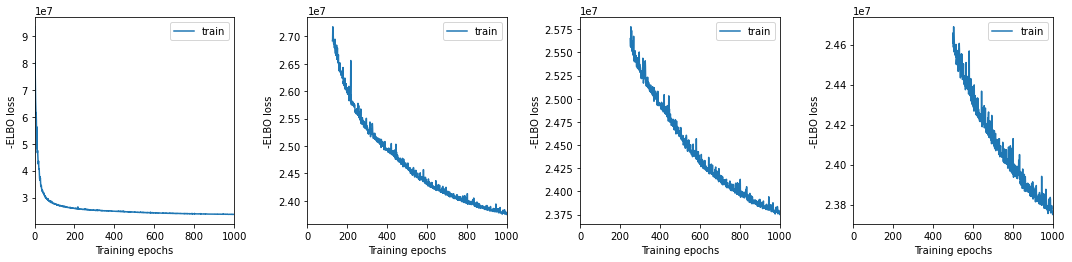

In [10]:
mod.max_epochs = max_epochs
mod.view_history()

Here we export the model posterior to the anndata object and calculate some useful quantities like RNAvelocity based on it.

In [11]:
adata = mod.export_posterior(adata,
                 sample_kwargs = {"num_samples": posterior_samples, "batch_size" : adata.n_obs,
                                  "use_gpu" : True, 'return_samples': True},
                 full_velocity_posterior = True)

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.29it/s]


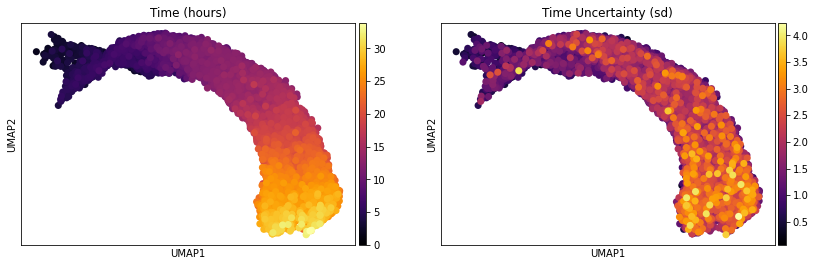

In [12]:
sc.pl.umap(adata, color = ['Time (hours)', 'Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2)

T_mON [[[ 0.         2.2615952  5.851308   9.693034  17.395203 ]]]
T_mOFF [[[18.514389  9.757204 29.474277 35.604176 38.519726]]]
Tmax 29.037354


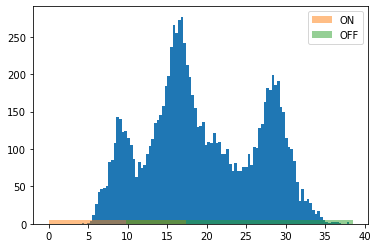

In [13]:
import matplotlib.pyplot as plt
plt.hist(mod.samples['post_sample_means']['T_c'].flatten(), bins = 100)
plt.hist(mod.samples['post_sample_means']['T_mON'].flatten(), bins = 1, alpha = 0.5, label = 'ON')
plt.hist(mod.samples['post_sample_means']['T_mOFF'].flatten(), bins = 1, alpha = 0.5, label = 'OFF')
plt.legend()
print('T_mON', mod.samples['post_sample_means']['T_mON'])
print('T_mOFF', mod.samples['post_sample_means']['T_mOFF'])
print('Tmax', mod.samples['post_sample_means']['Tmax'])

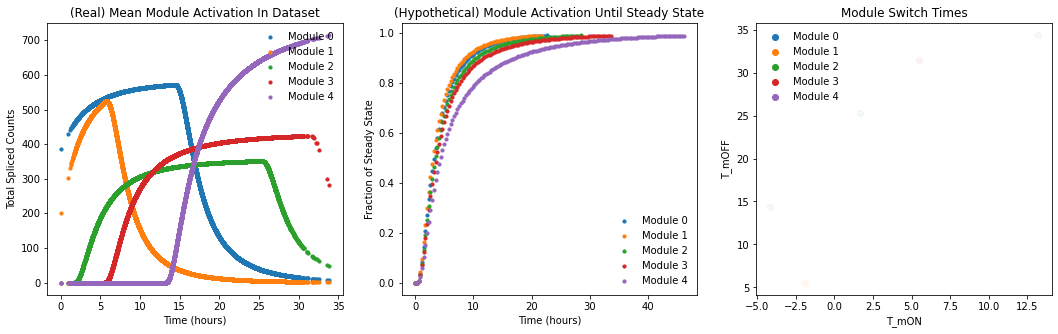

In [14]:
mod.compare_module_activation(adata, chosen_modules = [range(n_modules)], max_time_steps = 200, interval = 0.01)

In [15]:
# adata.obs['spliced_log10_total'] = np.log10(np.sum(adata.layers['spliced'], axis = 1))
# adata.obs['unspliced_log10_total'] = np.log10(np.sum(adata.layers['unspliced'], axis = 1))
# adata.obs['spliced_total'] = np.sum(adata.layers['spliced'], axis = 1)
# adata.obs['unspliced_total'] = np.sum(adata.layers['unspliced'], axis = 1)
# adata.obs['unspliced_spliced_ratio'] = np.sum(adata.layers['unspliced'], axis = 1)/np.sum(adata.layers['spliced'], axis = 1)
# sc.pl.umap(adata, color = ['spliced_log10_total', 'unspliced_log10_total',
#                            'spliced_total', 'unspliced_total',
#                            'unspliced_spliced_ratio'],
#            legend_loc = 'right margin', size = 200, color_map = 'inferno', ncols = 2)

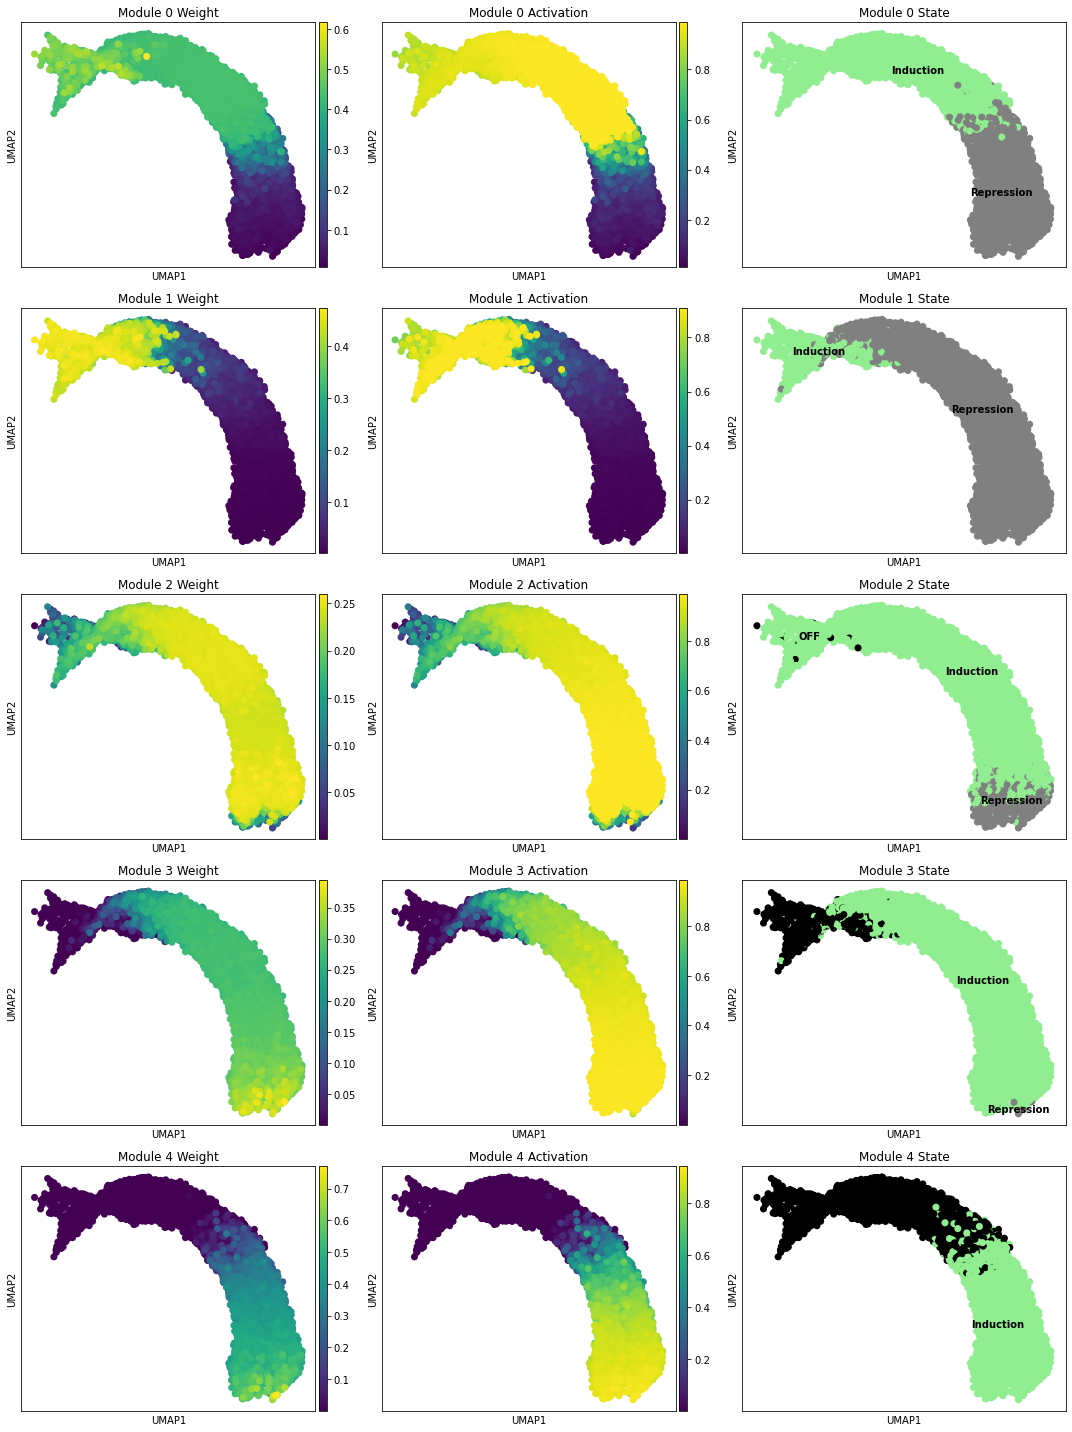

In [16]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata)

In [17]:
# for i in range(n_modules):
#     adata.obs['Module Weight']

(array([2552.,  547.,  305.,  234.,  213.,  163.,  139.,  140.,  348.,
        5174.]),
 array([0.01021887, 0.10791958, 0.20562029, 0.303321  , 0.40102172,
        0.49872243, 0.59642315, 0.69412386, 0.7918246 , 0.8895253 ,
        0.987226  ], dtype=float32),
 <BarContainer object of 10 artists>)

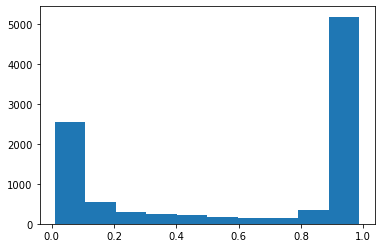

In [18]:
plt.hist(adata.obs['Module 0 Activation'])

In [ ]:
mod.compute_and_plot_module_velocity(adata)

Computing velocity produced by Module 0 ...
computing neighbors
    finished (0:01:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:02) --> added
    'Module 0 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 1 ...
computing neighbors
    finished (0:00:50) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:02) --> added
    'Module 1 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 2 ...
computing neighbors
    finished (0:00:50) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:02) --> added
    'Module 2 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 3 ...
computing neighbors
    finished

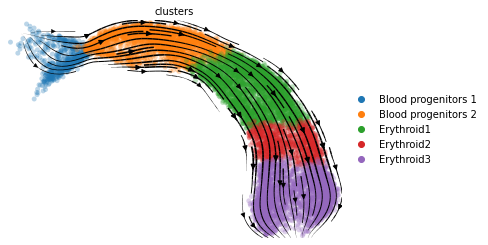

In [20]:
mod.compute_and_plot_total_velocity(adata)

(array([ 810., 2654., 2810., 1748., 1000.,  509.,  177.,   68.,   29.,
          10.]),
 array([ 1346. ,  2730.9,  4115.8,  5500.7,  6885.6,  8270.5,  9655.4,
        11040.3, 12425.2, 13810.1, 15195. ], dtype=float32),
 <BarContainer object of 10 artists>)

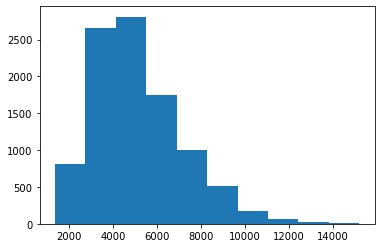

In [21]:
import matplotlib.pyplot as plt
plt.hist(np.sum(adata.layers['spliced'], axis = 1))

(array([ 231., 1113., 1028., 2300., 1366.,  876., 1137., 1463.,  282.,
          19.]),
 array([ 0.       ,  3.3882709,  6.7765417, 10.164813 , 13.553083 ,
        16.941355 , 20.329626 , 23.717897 , 27.106167 , 30.494438 ,
        33.88271  ], dtype=float32),
 <BarContainer object of 10 artists>)

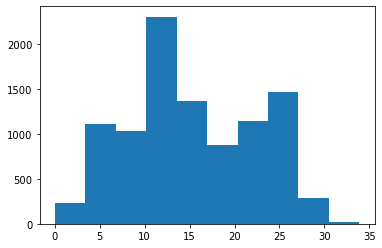

In [22]:
plt.hist(mod.samples['post_sample_means']['T_c'].flatten() - np.min(mod.samples['post_sample_means']['T_c'].flatten()))

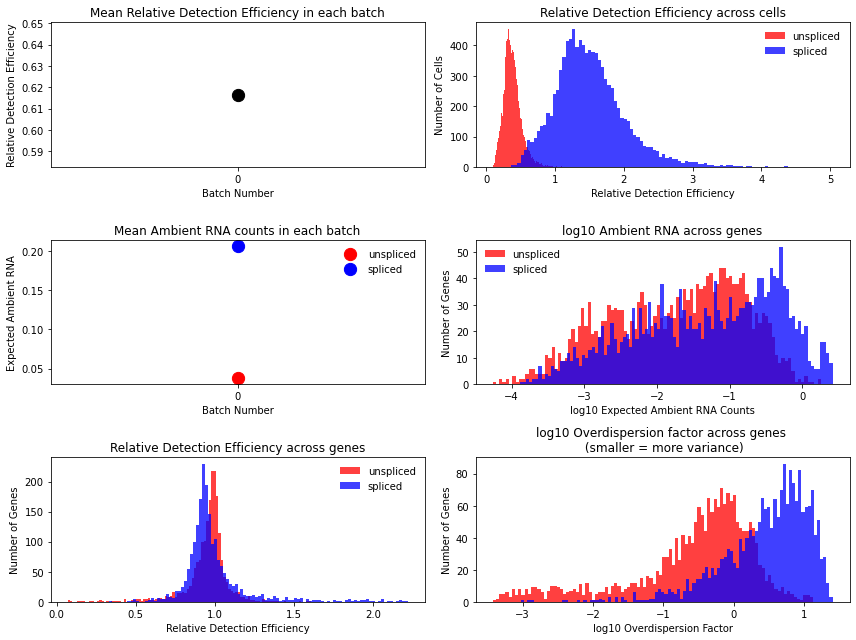

In [23]:
mod.plot_technical_variables(adata)

In [24]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.10497644
gamma_g mean: 0.55320245
beta_g mean: 1.4213475
lam_mi, all modules: 
 
 [[[3.61 2.2 ]]

 [[4.28 2.56]]

 [[3.54 2.36]]

 [[3.4  2.03]]

 [[3.58 2.33]]]


In [25]:
tab = mod.get_module_top_features(adata, p_adj_cutoff=0.1)
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Gm15915, Parm1, Abcg1, Mmp15, Scube2, Vegfb, S...","Ikzf2, Myb, Camta1, Zfp428, Runx1, Hmga1, Tet1...","platelet degranulation (GO:0002576), regulatio..."
1,1,"Flt1, Cdh5, Rspo3, Mest, Unc5c, Igf1, Nrg1, Af...","Aff3, Zfp608, Erg, Gata2, Meis1, Plek, Elk3, H...","regulation of angiogenesis (GO:0045765), posit..."
2,2,"Zfp982, Gtf2ird1, Smn1, Nop14, Tmem87b, Ano2, ...","Hif1a, Zfp282, Zfp346, Rc3h2, Tfam, Nono, Cebp...","mRNA splicing, via spliceosome (GO:0000398), R..."
3,3,"Emilin2, Picalm, Mt2, Slc16a6, Olfm1, Gabra4, ...","E2f2, Klf1, Atf1, E2f1, Zfp704, Zfpm1, Noc3l, ...",DNA integrity checkpoint signaling (GO:0031570...
4,4,"Slc4a1, Prr13, Hebp1, Pklr, Rhag, Klf3, 603046...","Klf3, Arid3a, Mllt3, Xbp1, Clock, Elf1, Runx1t...","heme biosynthetic process (GO:0006783), porphy..."


In [26]:
tab['Terms Ranked'].iloc[2]

'mRNA splicing, via spliceosome (GO:0000398), RNA splicing, via transesterification reactions with bulged adenosine as nucleophile (GO:0000377), mRNA processing (GO:0006397), DNA replication (GO:0006260), positive regulation of cell division (GO:0051781), mitotic DNA replication checkpoint signaling (GO:0033314), DNA metabolic process (GO:0006259), DNA repair (GO:0006281), interstrand cross-link repair (GO:0036297), rRNA metabolic process (GO:0016072), mitotic DNA integrity checkpoint signaling (GO:0044774), RNA biosynthetic process (GO:0032774), positive regulation of cytokinesis (GO:0032467), positive regulation of cell cycle process (GO:0090068), DNA replication initiation (GO:0006270), DNA replication checkpoint signaling (GO:0000076), protein localization to chromosome, centromeric region (GO:0071459), ribosome biogenesis (GO:0042254), nucleic acid metabolic process (GO:0090304), translesion synthesis (GO:0019985), regulation of stem cell population maintenance (GO:2000036), DNA s

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


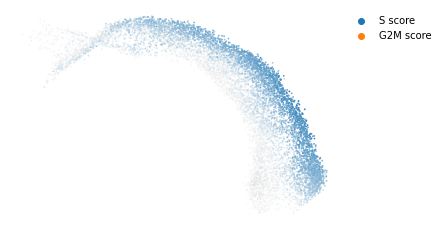

In [27]:
import scvelo as scv
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

This is how we can save the model and anndata object for later use:

In [28]:
save = False
if save:
    # Make an interpretable name for this run:
    run_name = savings_directory + 'PancreasData' + '+Genes_' + str(len(adata.var_names)) + \
    '+Cells_' + str(len(adata.obs_names)) +  \
    '+Model_Cell2fate_ModularTranscriptionRate_NoSplicing_2' + '+Modules_' + str(max_modules) \
    + '+Lineages_' + str(max_lineages) + '+TrainingEpochs_' + str(max_epochs) \
    + '+LearningRate_' + str(learning_rate) + '+BatchSize_' + str(batch_size) + '+PosteriorSamples_' + str(posterior_samples)
    adata_file = run_name + "/anndata.h5ad"
    # Save model:
    mod.save(f"{run_name}", overwrite=True)
    # Save adata object:
    adata.write(adata_file)

This is how we can load the model again:

In [29]:
# adata = sc.read_h5ad(adata_file)
# mod = c2f.Cell2fate_ModularTranscriptionRate_FixedModules.load(f"{run_name}", adata)

In [30]:
'test'

'test'